**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Importing libraries and setting dependencies
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import sympy as sp
import ipywidgets as widgets
from scipy.optimize import minimize_scalar
from scipy import optimize
import pandas as pd
from scipy.optimize import minimize

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
# Defining parameters and variables

c = sp.symbols('C', positive = True, real = True) # Private consumption 
alpha = sp.symbols('alpha', positive = True, real = True) # Weight for private consumption 
g = sp.symbols('G', positive = True, real = True) # Government spending
v = sp.symbols('v', positive = True, real = True) # Disutility of labor scaling factor 
l = sp.symbols('L', positive = True, real = True) # Labor hours
kappa = sp.symbols('kappa', positive = True, real = True) # Free private consumption
tau = sp.symbols('tau', positive = True, real = True) # Tax rate
w = sp.symbols('w', positive = True, real = True) # Real wage
wtilde = sp.symbols('wtilde', positive = True, real = True)

# Setting up and displaying the utility function

utility = sp.log(c**alpha*g**(1-alpha))-v*l**2/2

print('Displaying the utility function:')
display(sp.Eq(sp.symbols('U'),utility))

# Defining the constraint and substituting it into the utility function, after which we solve for the optimal level of L

constraint = kappa+wtilde*l

utilitysub = utility.subs(c, constraint) # Substituting the constraint into the utility function

print('Substituting the budget constraint into the utility function we get:')

display(sp.Eq(sp.symbols('U'),utilitysub)) # Displaying the new utility function

print('Taking the first-order-condition for the utility function yields:')

foc = sp.Eq(sp.diff(utilitysub, l),0) # Taking the derivative to find the FOC

display(foc) # Displaying the FOC

print('Solving for L gives us the optimal level of working hours:')

sol = sp.solve(foc, l)[0] # Solving the FOC wrt. L

display(sp.Eq(sp.symbols('L^*'),sol)) # Displaying the solution

print('Which can be shown to be the same as the solution presented in the question.')

Displaying the utility function:


Eq(U, -L**2*v/2 + log(C**alpha*G**(1 - alpha)))

Substituting the budget constraint into the utility function we get:


Eq(U, -L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha))

Taking the first-order-condition for the utility function yields:


Eq(G**(1 - alpha)*G**(alpha - 1)*alpha*wtilde/(L*wtilde + kappa) - L*v, 0)

Solving for L gives us the optimal level of working hours:


Eq(L^*, -kappa/(2*wtilde) + sqrt(4*alpha*wtilde**2 + kappa**2*v)/(2*sqrt(v)*wtilde))

Which can be shown to be the same as the solution presented in the question.


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

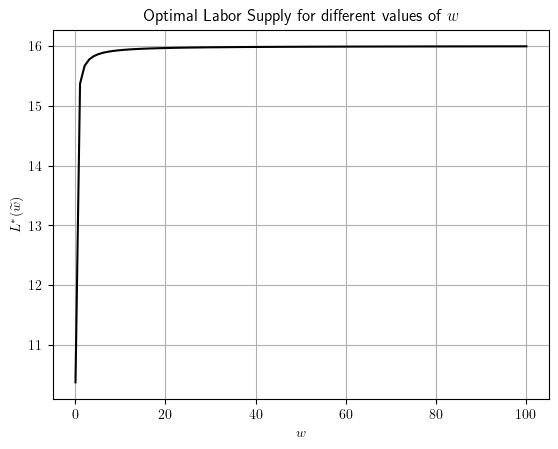

In [3]:
# The optimal labor supply choice is given, and we define it as a function by
def optimal_labor_supply(w, k, a, v, t):
    opt = (1 - t) * w
    L_opt = (-k + np.sqrt(k**2 + (4 * a / v) * opt**2)) / (2 * opt)
    return L_opt

# Returning utility maximizing values of labor given the parameter values. 
# Now, we set an arbitrary interval of values for w to plot together with parameter values

w_values = np.linspace(0.1, 100, 100)

k = 1
a = 0.5
v = 1/(2*16**2)
t = 0.3

# Looping through optimale values for all w values defined above
optimal_labor = [optimal_labor_supply(w, k, a, v, t) for w in w_values]

# Plotting the results
plt.plot(w_values, optimal_labor, color="black")
plt.xlabel(r'$w$')
plt.ylabel(r'$L^*(\widetilde{w})$')
plt.title(r'Optimal Labor Supply for different values of $w$')
plt.grid(True)
plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


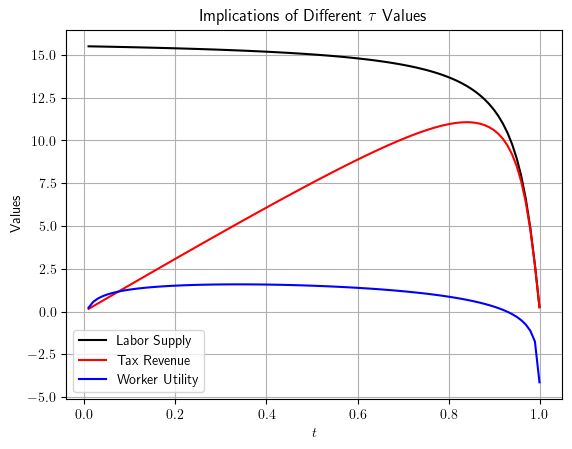

In [4]:
# The optimal labor supply choice is given, and we define it as a function
def optimal_labor_supply(w, k, a, v, t):
    opt = (1 - t) * w
    L_opt = (-k + np.sqrt(k**2 + (4 * a / v) * opt**2)) / (2 * opt)
    return L_opt

# Defining the corresponding worker utility
def worker_utility(w, k, a, v, t):
    opt = (1 - t) * w
    L_opt = (-k + np.sqrt(k**2 + (4 * a / v) * opt**2)) / (2 * opt)
    c = k + (1-t)*w*L_opt
    G = t*w*L_opt*((1-t)*w)
    utility = np.log(c**a*G**(1-a)) - (v*L_opt**2)/2
    return utility

# Setting grid of t-values
t_values = np.linspace(0.01, 0.999, 100)

# Setting baseline parameter values
w = 1
k = 1
a = 0.5
v = 1 / (2 * 16**2)

# Calculate optimal labor supply, government consumption, and worker utility for each t value using list comprehensions
optimal_labor = [optimal_labor_supply(w, k, a, v, t) for t in t_values]
government_consumption = [t * w * optimal_labor_supply(w, k, a, v, t)  for t in t_values]
worker_utilities = [worker_utility(w, k, a, v, t) for t in t_values]

# Plotting the results
plt.plot(t_values, optimal_labor, label='Labor Supply', color="black")
plt.plot(t_values, government_consumption, label='Tax Revenue', color="red")
plt.plot(t_values, worker_utilities, label='Worker Utility', color="blue")
plt.xlabel(r'$t$')
plt.ylabel('Values')
plt.title(r'Implications of Different $\tau$ Values')
plt.legend()
plt.grid(True)
plt.show()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

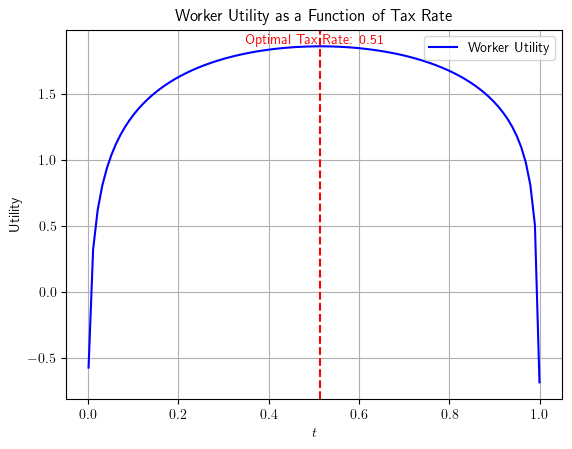

The socially optimal tax rate that maximizes worker utility is: 0.51


In [5]:
# The optimal labor supply choice is given, and we define it as a function
def optimal_labor_supply(w, k, a, v, t):
    opt = (1 - t) * w
    L_opt = (-k + np.sqrt(k**2 + (4 * a / v) * opt**2)) / (2 * opt)
    return L_opt

# Defining the corresponding worker utility
def worker_utility(w, k, a, v, t):
    opt = (1 - t) * w
    L_opt = (-k + np.sqrt(k**2 + (4 * a / v) * opt**2)) / (2 * opt)
    c = k + (1-t)*w*L_opt
    G = t*w*L_opt
    utility = np.log(c**a*G**(1-a)) - (v*L_opt**2)/2
    return utility

# Objective function to maximize worker utility
def objective(t, w, k, a, v):
    return -worker_utility(w, k, a, v, t)

# Setting baseline parameter values
w = 1
k = 1
a = 0.5
v = 1 / (2 * 16**2)

# Find the socially optimal tax rate that maximizes worker utility
res = minimize_scalar(objective, args=(w, k, a, v), bounds=(0, 1), method='bounded')
optimal_tax_rate = res.x
optimal_worker_utility = -res.fun

# Generate a plot to illustrate the results
t_values = np.linspace(0.002, 0.999, 100)
worker_utilities = [worker_utility(w, k, a, v, t) for t in t_values]

plt.plot(t_values, worker_utilities, label='Worker Utility', color="blue")
plt.axvline(x=optimal_tax_rate, color='red', linestyle='--')
plt.xlabel(r'$t$')
plt.ylabel('Utility')
plt.title(r'Worker Utility as a Function of Tax Rate')
plt.legend()
plt.grid(True)

# Add optimal tax rate as a legend
plt.text(0.5, np.max(worker_utilities), f'Optimal Tax Rate: {optimal_tax_rate:.2f}', ha='center', va='bottom', color='red')

plt.show()

print(f'The socially optimal tax rate that maximizes worker utility is: {optimal_tax_rate:.2f}')


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [6]:

# Defining labor and utility functions
def find_optimal_labor(w, t, G, a, sigma, rho, v, epsilon, k):
    def utility_function(L, w, t, G, a, sigma, rho, v, epsilon, k):
        C = k + (1 - t) * w * L
        utility = ((a * C**((sigma - 1) / sigma) + (1 - a) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1)))**(1 - rho) / (1 - rho) - v * (L**(1 + epsilon)) / (1 + epsilon)
        return -utility

    bounds = [(0, 24)]  # Labor supply bounds [0, 24]
    result = optimize.minimize(utility_function, x0=12, args=(w, t, G, a, sigma, rho, v, epsilon, k), bounds=bounds, method='SLSQP')
    optimal_labor = result.x[0]
    utility = result.fun
    return optimal_labor, utility

# Set global parameters that stays constant
t = optimal_tax_rate
epsilon = 1.0
G = 1 

# Setting scenario 1 parameters
sigma_1 = 1.001
rho_1 = 1.001

# Calculating optimal labor with parameter scenario 1
L_1, U_1 = find_optimal_labor(w, t, G, a, sigma_1, rho_1, v, epsilon, k)

# And the corresponding optimal G
G_1 = t * w * L_1

# Setting scneario 2 parameters
sigma_2 = 1.5
rho_2 = 1.5

# Calculating optimal labor with parameter scenario 2
L_2, U_2 = find_optimal_labor(w, t, G, a, sigma_2, rho_2, v, epsilon, k)

# And the corresponding optimal G
G_2 = t * w * L_2

print(f'Optimal G in scenario 1 is: {G_1}')
print(f'Optimal G in scenario 2 is: {G_2}')

Optimal G in scenario 1 is: 7.715875304059423
Optimal G in scenario 2 is: 6.578766083389268


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [7]:
# Since we have now calculated the optimal G and know L* and w we can isolate tau in the above to read: tau = G/(w*L^*) and thus

tau_1 = G_1/(w*L_1)
tau_2 = G_2/(w*L_2)

# Printing the optimal tax rate in either scenario
tau_1, tau_2

(0.5145311213913639, 0.5145311213913639)

Thus the socially optimal tax rate maximizing worker utility is $\tau^* = 0.5145$ when $\sigma = \rho$, which is also why the optimal tax rate is the same in the output above for scenario 1 and 2. 

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

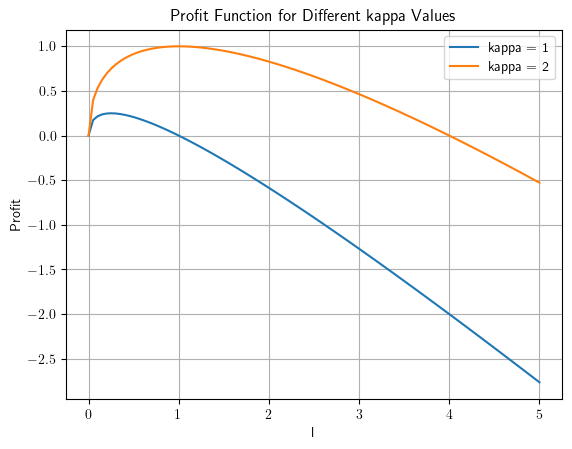

In [8]:
# Profit function
def profit_function(k, l, n, w):
    return k * l**(1 - n) - w * l

# Baseline parameters
k_values = [1, 2]
n = 0.5
w = 1

# Range of l values
l_values = np.linspace(0, 5, 100)

# Plotting the profit function for each kappa value
for k in k_values:
    profits = profit_function(k, l_values, n, w)
    plt.plot(l_values, profits, label=f'kappa = {k}')

plt.xlabel('l')
plt.ylabel('Profit')
plt.title('Profit Function for Different kappa Values')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
for kappa in k_values:
    # Calculate the value of l
    l = ((1 - n) * kappa / w)**(1 / n)
    
    # Calculate the profit
    profit = profit_function(kappa, l, n, w)
    
    print(f"For kappa = {kappa}, l = {l:.4f}, Profit = {profit:.4f}")

For kappa = 1, l = 0.2500, Profit = 0.2500
For kappa = 2, l = 1.0000, Profit = 1.0000


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [10]:
# Defining parameters 

rho = 0.9 # Convergence coefficient for kappa
i = 0.01 # Fixed labor adjustment costs
eta = 0.5 
w = 1
sigma = 0.1 # Standard deviation
R = (1+0.01)**(1/12) # Monthly interest rate
K = 1000 # Number of times to run the simulation. Set high such that the results doesn't fluctuate too much

# Running the dynamic version of the model
K_h = [] # Creating an empty list for the ex post value of the salon

# Creating a loop that runs the model K times
for j in range(K):
    
    kappa = [1] # Defining initial vlaue for kappa

    for t in range(120): # Running the AR simulation for kappa
        kappa_t = rho*np.log(kappa[t-1])+np.random.normal(loc=-0.5*sigma**2, scale=sigma)
        kappa.append(np.exp(kappa_t))

    ell = [0] # Defining initial value for ell

    for t in range(1,120): # Calculating optimal value of ell for all periods
        ell.append(((1-eta)*kappa[t]/w)**(1/eta))

    h_t = [] # Creating an empty list for the ex post value of the salon in each period t

    for t in range (120): # Calculating the ex post value of the salon in each period t
        if ell[t] != ell[t-1]:
            h_t.append(R**(-t)*(kappa[t]*ell[t]**(1-eta)-w*ell[t]-i))
        else: 
            h_t.append(R**(-t)*(kappa[t]*ell[t]**(1-eta)-w*ell[t]))

    h=sum(h_t) # Finding the ex post value as the sum of all individual contributions

    K_h.append(h) # Summing the ex post value for all simulations K

H = 1/K*sum(K_h) # Finding the ex ante value for the salon

# Printing the results
print('The ex ante value for the salon is:', H)

The ex ante value for the salon is: 27.36069141709229


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [11]:
# Defining parameters 

rho = 0.9 # Convergence coefficient for kappa
i = 0.01 # Fixed labor adjustment costs
sigma = 0.1 # Standard deviation
R = (1+0.01)**(1/12) # Monthly interest rate
Delta = 0.05 # Delta
K = 1000 # Number of times to run the simulation. Set high such that the results doesn't fluctuate too much

# Running the dynamic version of the model with the new policy

K_h = [] # Creating an empty list for the ex post value of the salon

# Creating a loop that runs the model K times

for j in range(K):
    
    kappa = [1] # Defining initial vlaue for kappa

    for t in range(120): # Running the AR simulation for kappa
        kappa_t = rho*np.log(kappa[t-1])+np.random.normal(loc=-0.5*sigma**2, scale=sigma)
        kappa.append(np.exp(kappa_t))

    ell = [0] # Defining initial value for ell

    for t in range(1,120): # Applying the policy to the determination of ell
        if abs(ell[t - 1]-((1-eta)*kappa[t]/w)**(1/eta)) > Delta:
            ell.append(((1-eta)*kappa[t]/w)**(1/eta))
        else:
            ell.append(ell[t-1])

    h_t = [] # Creating an empty list for the ex post value of the salon in each period t

    for t in range (120): # Calculating the ex post value of the salon in each period t
        if ell[t] != ell[t-1]:
            h_t.append(R**(-t)*(kappa[t]*ell[t]**(1-eta)-w*ell[t]-i))
        else: 
            h_t.append(R**(-t)*(kappa[t]*ell[t]**(1-eta)-w*ell[t]))

    h=sum(h_t) # Finding the ex post value as the sum of all individual contributions

    K_h.append(h) # Summing the ex post value for all simulations K

H = 1/K*sum(K_h) # Finding the ex ante value for the salon

# Printing the results

print('The ex ante value for the salon with the new policy is:', H)


The ex ante value for the salon with the new policy is: 27.768636085833997


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

The max value for H is: 28.167134117793996
With an optimal Delta value of: 0.061224489795918366


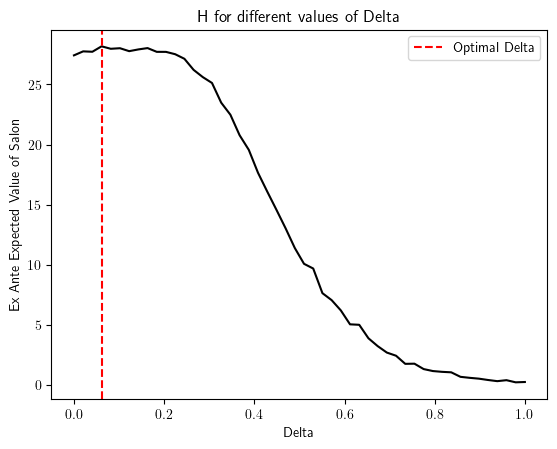

In [12]:
# Defining parameters

rho = 0.9
i = 0.01
sigma = 0.1
R = (1 + 0.01) ** (1 / 12)
K = 1000

# Define a list of Delta values
delta_values = np.linspace(0,1,50)

# Create an empty list to store H values
H_values = []

# Running the same simulation as in question 3, now just for different delta values
for delta in delta_values:
    K_h = []

    for j in range(K):
        kappa = [1]

        for t in range(120):
            kappa_t = rho * np.log(kappa[t - 1]) + np.random.normal(loc=-0.5 * sigma**2, scale=sigma)
            kappa.append(np.exp(kappa_t))

        ell = [0]
        eta = 0.5 
        w = 1  

        for t in range(1,120):
            if abs(ell[t - 1]-((1-eta)*kappa[t]/w)**(1/eta)) > delta:
                ell.append(((1 - eta) * kappa[t] / w) ** (1 / eta))
            else:
                ell.append(ell[t - 1])

        h_t = []

        for t in range(120):
            if ell[t] != ell[t - 1]:
                h_t.append(R ** (-t) * (kappa[t] * ell[t] ** (1 - eta) - w * ell[t] - i))
            else:
                h_t.append(R ** (-t) * (kappa[t] * ell[t] ** (1 - eta) - w * ell[t]))

        h = sum(h_t)
        K_h.append(h)

    H = 1 / K * sum(K_h)

    # Append H value to the list
    H_values.append(H)


# Creating a dataframe with Delta and H values
df = pd.DataFrame(columns=['Delta', 'H'])

df['Delta']=delta_values
df['H']=H_values

# Finding the maximal value of H, and the corresponding delta value

max_H = max(df['H'])
max_H_index = df['H'].idxmax()
max_delta = df.loc[max_H_index, 'Delta']
print('The max value for H is:',max_H)
print('With an optimal Delta value of:',max_delta)

# Plotting H for different values of Delta

plt.plot(delta_values, H_values, color="black")
plt.ylabel('Ex Ante Expected Value of Salon') # Setting label for y-axis
plt.xlabel('Delta') # Setting label for x-axis
plt.title('H for different values of Delta') # Setting title
plt.axvline(x=max_delta, color='red', linestyle='dashed', label='Optimal Delta') # Plotting a vertical line for the optimal delta value
plt.legend() # Inserting legend
plt.show() # Plotting the plot


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



We saw in question 4 that the optimal value of $\Delta$ was above 0, which might at first seem counterintuitive, since $\ell$ diverges from $\ell^*$. However $H$ can be higher with $\Delta>0$, since $\ell_t=\ell_{t-1}$ removes the fixed costs. With that in mind, we have tried to come up with a policy that takes this to the extremes by making sure that the fixed costs will be removed in almost all periods. The strategy can be formulated as:


$$
\ell_{t}=\begin{cases}
\ell_{t=1}^{\ast}  & \text{for} \ 0\leq t \leq 29\\
\ell_{t=30}^{\ast}  & \text{for} \ 30\leq t \leq 59\\
\ell_{t=60}^{\ast}  & \text{for} \ 60\leq t \leq 89\\
\ell_{t=90}^{\ast}  & \text{for} \ 90\leq t \leq 119\\
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$

Such that the $\ell_t$ is fixed for 30 periods at a time.

In [13]:
# Defining parameters 

rho = 0.9 
i = 0.01
sigma = 0.1
R = (1+0.01)**(1/12)
K = 1000

# Running the model as before, the only addition being the new policy

K_h = []

for j in range(K):
    
    kappa = [1]

    for t in range(120):
        kappa_t = rho*np.log(kappa[t-1])+np.random.normal(loc=-0.5*sigma**2, scale=sigma)
        kappa.append(np.exp(kappa_t))

    ell = [0]

    # Implementing the policy

    for t in range(1,30):
        ell.append(((1-eta)*kappa[1]/w)**(1/eta))
    
    for t in range(30,60):
        ell.append(((1-eta)*kappa[30]/w)**(1/eta))
    
    for t in range(60,90):
        ell.append(((1-eta)*kappa[60]/w)**(1/eta))
    
    for t in range(90,120):
        ell.append(((1-eta)*kappa[30]/w)**(1/eta))

    h_t = []

    for t in range (120):
        h_t.append(R**(-t)*(kappa[t]*ell[t]**(1-eta)-w*ell[t]))

    h=sum(h_t)

    K_h.append(h)

H = 1/K*sum(K_h)

# Printing the results

print('The ex ante value of the salon using this policy will be:', H)
print('The policy hence does not improve profitability by removing the fixed cost, which was what improved profitability with the last policy')


The ex ante value of the salon using this policy will be: 26.53373626872806
The policy hence does not improve profitability by removing the fixed cost, which was what improved profitability with the last policy


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [14]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

Optimal solution:
x1 = -1.9420949683501166e-09
x2 = -8.215203629866583e-09
Minimum value = 0.0


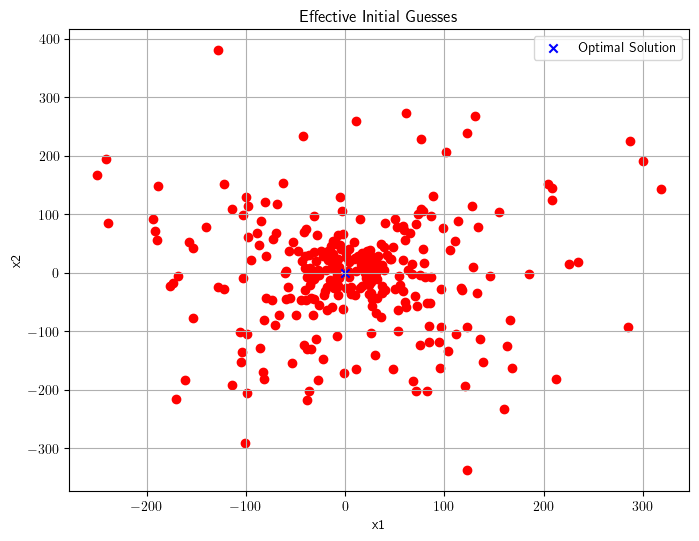

In [15]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def griewank(x):
    return griewank_(x[0], x[1])

def griewank_(x1, x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1)) * np.cos(x2/np.sqrt(2))
    return A - B + 1

def refined_global_optimizer(bounds, tolerance, warmup_iterations, max_iterations):
    best_x = None
    best_value = None
    initial_guesses = []  # Store initial guesses
    
    for k in range(max_iterations):
        x_k = np.random.uniform(bounds[0], bounds[1])  # Step 3.A
        
        if k >= warmup_iterations:
            chi_k = 0.50 * (2 / (1 + np.exp((k - warmup_iterations) / 100)))  # Step 3.C
            x_k0 = chi_k * x_k + (1 - chi_k) * best_x  # Step 3.D
            initial_guesses.append(x_k0)  # Store initial guess
            x0 = x_k0
        else:
            x0 = x_k
        
        result = minimize(griewank, x0, method='BFGS', tol=tolerance)  # Step 3.E
        
        if best_value is None or result.fun < best_value:  # Step 3.F
            best_x = result.x
            best_value = result.fun
        
        if best_value < tolerance:  # Step 3.G
            break
    
    return best_x, initial_guesses

# Settings
bounds = [np.array([-600, -600]), np.array([600, 600])]
tolerance = 1e-8
warmup_iterations = 10
max_iterations = 1000

# Perform optimization
result, initial_guesses = refined_global_optimizer(bounds, tolerance, warmup_iterations, max_iterations)

print("Optimal solution:")
print("x1 =", result[0])
print("x2 =", result[1])
print("Minimum value =", griewank(result))

# Plotting initial guesses
plt.figure(figsize=(8, 6))
plt.scatter([guess[0] for guess in initial_guesses], [guess[1] for guess in initial_guesses], c='r', marker='o')
plt.scatter(result[0], result[1], c='b', marker='x', label='Optimal Solution')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Effective Initial Guesses")
plt.legend()
plt.grid(True)
plt.show()


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

Optimal solution:
x1 = -6.3001483367997065e-09
x2 = 1.9959865358598355e-09
Minimum value = 0.0


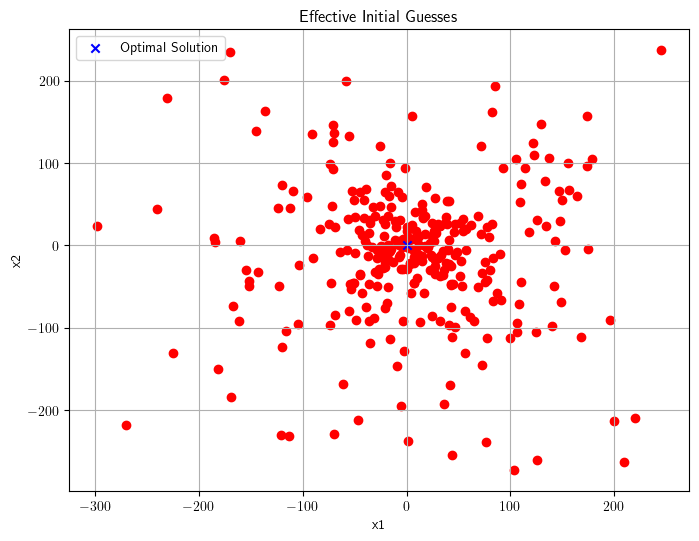

In [16]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def griewank(x):
    return griewank_(x[0], x[1])

def griewank_(x1, x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1)) * np.cos(x2/np.sqrt(2))
    return A - B + 1

def refined_global_optimizer(bounds, tolerance, warmup_iterations, max_iterations):
    best_x = None
    best_value = None
    initial_guesses = []  # Store initial guesses
    
    for k in range(max_iterations):
        x_k = np.random.uniform(bounds[0], bounds[1])  # Step 3.A
        
        if k >= warmup_iterations:
            chi_k = 0.50 * (2 / (1 + np.exp((k - warmup_iterations) / 100)))  # Step 3.C
            x_k0 = chi_k * x_k + (1 - chi_k) * best_x  # Step 3.D
            initial_guesses.append(x_k0)  # Store initial guess
            x0 = x_k0
        else:
            x0 = x_k
        
        result = minimize(griewank, x0, method='BFGS', tol=tolerance)  # Step 3.E
        
        if best_value is None or result.fun < best_value:  # Step 3.F
            best_x = result.x
            best_value = result.fun
        
        if best_value < tolerance:  # Step 3.G
            break
    
    return best_x, initial_guesses

# Settings
bounds = [np.array([-600, -600]), np.array([600, 600])]
tolerance = 1e-8
warmup_iterations = 100  # Updated value
max_iterations = 1000

# Perform optimization
result, initial_guesses = refined_global_optimizer(bounds, tolerance, warmup_iterations, max_iterations)

print("Optimal solution:")
print("x1 =", result[0])
print("x2 =", result[1])
print("Minimum value =", griewank(result))

# Plotting initial guesses
plt.figure(figsize=(8, 6))
plt.scatter([guess[0] for guess in initial_guesses], [guess[1] for guess in initial_guesses], c='r', marker='o')
plt.scatter(result[0], result[1], c='b', marker='x', label='Optimal Solution')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Effective Initial Guesses")
plt.legend()
plt.grid(True)
plt.show()

To see if setting $\underline{K} = 100$ impacts the convergence speed positively we track the number of each iteration needed to find the optimal solution and store these. We do this in the following code

In [17]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def griewank(x):
    return griewank_(x[0], x[1])

def griewank_(x1, x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1)) * np.cos(x2/np.sqrt(2))
    return A - B + 1

def refined_global_optimizer(bounds, tolerance, warmup_iterations, max_iterations):
    best_x = None
    best_value = None
    initial_guesses = []  # Store initial guesses
    iterations = 0  # Track number of iterations
    
    for k in range(max_iterations):
        x_k = np.random.uniform(bounds[0], bounds[1])  # Step 3.A
        
        if k >= warmup_iterations:
            chi_k = 0.50 * (2 / (1 + np.exp((k - warmup_iterations) / 100)))  # Step 3.C
            x_k0 = chi_k * x_k + (1 - chi_k) * best_x  # Step 3.D
            initial_guesses.append(x_k0)  # Store initial guess
            x0 = x_k0
        else:
            x0 = x_k
        
        result = minimize(griewank, x0, method='BFGS', tol=tolerance)  # Step 3.E
        
        if best_value is None or result.fun < best_value:  # Step 3.F
            best_x = result.x
            best_value = result.fun
        
        if best_value < tolerance:  # Step 3.G
            break
        
        iterations += 1
    
    return best_x, initial_guesses, iterations

# Settings
bounds = [np.array([-600, -600]), np.array([600, 600])]
tolerance = 1e-8
max_iterations = 1000

# Perform optimization with K = 10
warmup_iterations_k10 = 10
result_k10, _, iterations_k10 = refined_global_optimizer(bounds, tolerance, warmup_iterations_k10, max_iterations)

# Perform optimization with K = 100
warmup_iterations_k100 = 100
result_k100, _, iterations_k100 = refined_global_optimizer(bounds, tolerance, warmup_iterations_k100, max_iterations)

print("Optimal solution for K = 10:")
print("x1 =", result_k10[0])
print("x2 =", result_k10[1])
print("Minimum value =", griewank(result_k10))
print("Number of iterations for K = 10:", iterations_k10)

print("Optimal solution for K = 100:")
print("x1 =", result_k100[0])
print("x2 =", result_k100[1])
print("Minimum value =", griewank(result_k100))
print("Number of iterations for K = 100:", iterations_k100)


Optimal solution for K = 10:
x1 = -5.207411412302032e-09
x2 = -2.7754274462636597e-09
Minimum value = 0.0
Number of iterations for K = 10: 350
Optimal solution for K = 100:
x1 = -9.979655918659648e-09
x2 = -2.4284505710443948e-08
Minimum value = 1.1102230246251565e-16
Number of iterations for K = 100: 475


Since the number of iterations for $\underline{K}=100$ is 499 compared to 298 for $\underline{K}=10$ we can conclude that it is not necessarily a better idea to set $\underline{K} = 100$. 